In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import copy
import pandas as pd
import numpy as np
from datetime import datetime

from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import simple_network_sim.common as common
import simple_network_sim.loaders as loaders
import simple_network_sim.network_of_populations as ss
from simple_network_sim.sampleUseOfModel import build_args

def formatter(x, pos):
    return f"{x / 1e3:,.0f}k"

fmt = ticker.FuncFormatter(lambda x, pos: formatter(x, pos))

In [26]:
def run_model(network):
    
    infections = {}
    with open(args.input) as fp:
        infections = loaders.readInitialInfections(fp)

    disposableNetwork = copy.deepcopy(network)
    ss.exposeRegions(infections, disposableNetwork.states[0])
    ss.basicSimulationInternalAgeStructure(disposableNetwork, args.time)
    results = ss.modelStatesToPandas(disposableNetwork.states)
    
    return results


def aggregate_all_boards(results):
    return results.groupby(["time", "state"]).sum().reset_index().pivot(index="time", columns="state", values="total")


def bump_progression_field(progression_file, compartment_1, compartment_2, bump):
    with open(progression_file) as fp:
        progression = loaders.readCompartmentRatesByAge(fp)

    progression_bumped = progression.copy()

    for age in progression_bumped.keys():
        assert progression_bumped[age][compartment_1][compartment_2] != 0., f"{compartment_1} to {compartment_2} is 0."
        diff = np.clip(bump + progression_bumped[age][compartment_1][compartment_2], 0., 1.) - progression_bumped[age][compartment_1][compartment_2]
        progression_bumped[age][compartment_1][compartment_2] += diff
        
        for compartment_to_adjust in progression_bumped[age][compartment_1]:
            if compartment_to_adjust != compartment_2:
                progression_bumped[age][compartment_1][compartment_to_adjust] -= diff / (len(progression_bumped[age][compartment_1]) - 1)
    
    return progression_bumped


def bump_infection_matrix(infectionMatrix, age_range1, age_range2, bump):
    infectionMatrix_bumped = copy.deepcopy(infectionMatrix)
    infectionMatrix_bumped._matrix[age_range1]._entries[age_range2] = infectionMatrix_bumped._matrix[age_range1]._entries[age_range2] + bump
            
    return infectionMatrix_bumped


def bump_movementMultipliers(movementMultipliers, movement_bump, contact_bump):
    movementMultipliers_bumped = copy.deepcopy(movementMultipliers)
    
    for age in movementMultipliers:
        movementMultipliers_bumped[age] = loaders.Multiplier(max(0., movementMultipliers_bumped[age].movement + movement_bump), max(0., movementMultipliers_bumped[age].contact + contact_bump))

    return movementMultipliers_bumped


def create_args():
    argv = ['seeded', 'sample_input_files/initial_infection.csv', 'afilename.pdf']
    return build_args(argv)


def create_original_network(args):

    return ss.createNetworkOfPopulation(
        disasesProgressionFn=args.compartment_transition,
        populationFn=args.population,
        graphFn=args.commutes,
        ageInfectionMatrixFn=args.mixing_matrix,
        movementMultipliersFn=args.movement_multipliers,
    )

def create_network(progression, states, graph, infectionMatrix, movementMultipliers):    
    return ss.NetworkOfPopulation(copy.deepcopy(progression), copy.deepcopy(states), copy.deepcopy(graph), copy.deepcopy(infectionMatrix), copy.deepcopy(movementMultipliers))

args = create_args()

### Compartment transitions (include in Parameter sensitivity)

In [27]:
with open(args.compartment_transition) as fp:
    progression = loaders.readCompartmentRatesByAge(fp)
    
pd.concat([pd.DataFrame(f) for f in progression.values()], keys=progression.keys(), axis=1)

70+                                  [17,70)                              \
       E       A       I      H    R    D       E       A       I      H    R   
E  0.573     NaN     NaN    NaN  NaN  NaN   0.573     NaN     NaN    NaN  NaN   
A  0.427  0.8030     NaN    NaN  NaN  NaN   0.427  0.8030     NaN    NaN  NaN   
I    NaN  0.0197  0.6700    NaN  NaN  NaN     NaN  0.0197  0.6700    NaN  NaN   
R    NaN  0.1773  0.2640  0.058  1.0  NaN     NaN  0.1773  0.2640  0.058  1.0   
D    NaN     NaN  0.0165  0.042  NaN  1.0     NaN     NaN  0.0165  0.042  NaN   
H    NaN     NaN  0.0495  0.900  NaN  NaN     NaN     NaN  0.0495  0.900  NaN   

       [0,17)                                   
     D      E       A       I      H    R    D  
E  NaN  0.573     NaN     NaN    NaN  NaN  NaN  
A  NaN  0.427  0.8030     NaN    NaN  NaN  NaN  
I  NaN    NaN  0.0197  0.6700    NaN  NaN  NaN  
R  NaN    NaN  0.1773  0.2640  0.058  1.0  NaN  
D  1.0    NaN     NaN  0.0165  0.042  NaN  1.0  
H  NaN    NaN     NaN  0.0495  0.900  NaN  NaN

### Movement multipliers (include in Parameter sensitivity)

In [7]:
with open(args.movement_multipliers) as fp:
    movementMultipliers = loaders.readMovementMultipliers(fp)
    
movementMultipliers

{50: Multiplier(movement=0.05, contact=0.05),
 75: Multiplier(movement=0.3, contact=0.3),
 80: Multiplier(movement=0.8, contact=0.8),
 100: Multiplier(movement=0.9, contact=0.9)}

### Mixing matrix (include in Parameter sensitivity)

In [124]:
infectionMatrix = loaders.MixingMatrix(args.mixing_matrix)
print(infectionMatrix)

[0,17): [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]
[17,70): [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]
70+: [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]


### Population

In [28]:
with open(args.population) as fp:
    population = loaders.readPopulationAgeStructured(fp)
    
pd.DataFrame(population)

,S08000015,S08000016,S08000017,S08000019,S08000020,S08000022,S08000024,S08000025,S08000026,S08000028,S08000029,S08000030,S08000031,S08000032
"[0,17)",65307,20237,24842,55873,105607,55711,159238,3773,4448,4586,68150,71822,208091,125287
"[17,70)",245680,75008,96899,209221,404810,214008,635249,14707,15374,17367,250133,280547,829574,450850
70+,58683,20025,27049,40976,74133,52081,103283,3710,3168,4877,53627,63711,137315,83063


### Run model

### Debug one run

In [ ]:
infections = {}
with open(args.input) as fp:
    infections = loaders.readInitialInfections(fp)

disposableNetwork = copy.deepcopy(bumped_network)
ss.exposeRegions(infections, disposableNetwork.states[0])

multipliers = disposableNetwork.movementMultipliers.get(0, loaders.Multiplier(contact=1.0, movement=1.0))
for time in range(200):
    multipliers = disposableNetwork.movementMultipliers.get(time + 1, multipliers)

    progression = ss.getInternalProgressionAllNodes(disposableNetwork.states[time], disposableNetwork.progression)

    internalInfections = ss.getInternalInfection(disposableNetwork.states, disposableNetwork.infectionMatrix, time, multipliers.contact)
    externalInfections = ss.getExternalInfections(disposableNetwork.graph, disposableNetwork.states, time, multipliers.movement)
    exposed = ss.mergeExposed(internalInfections, externalInfections)

    disposableNetwork.states[time + 1] = ss.createNextStep(progression, exposed, disposableNetwork.states[time])

results = ss.modelStatesToPandas(disposableNetwork.states)

# Default Run

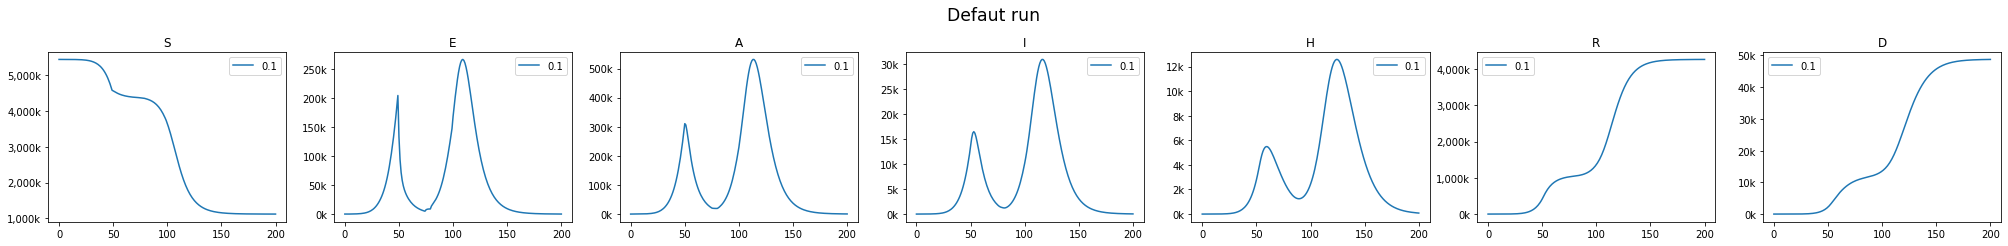

In [29]:
args = create_args()
network = create_original_network(args)
res = run_model(bumped_network)
res = aggregate_all_boards(res)

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 3.5), sharex=True)
fig.suptitle(f"Defaut run", fontsize='xx-large')
fig.subplots_adjust(top=0.8)
for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
    res[col].plot(ax=axes[i], title=col, label=bump)
    axes[i].set_xlabel('')
    axes[i].legend()
    axes[i].yaxis.set_major_formatter(fmt)

# Change wrt to compartment transition probabilities

In [88]:
pd.DataFrame(network.progression['70+'])

,E,A,I,H,R,D
E,0.573,NaN,NaN,NaN,NaN,NaN
A,0.427,0.8030,NaN,NaN,NaN,NaN
I,NaN,0.0197,0.6700,NaN,NaN,NaN
R,NaN,0.1773,0.2640,0.058,1.0,NaN
D,NaN,NaN,0.0165,0.042,NaN,1.0
H,NaN,NaN,0.0495,0.900,NaN,NaN


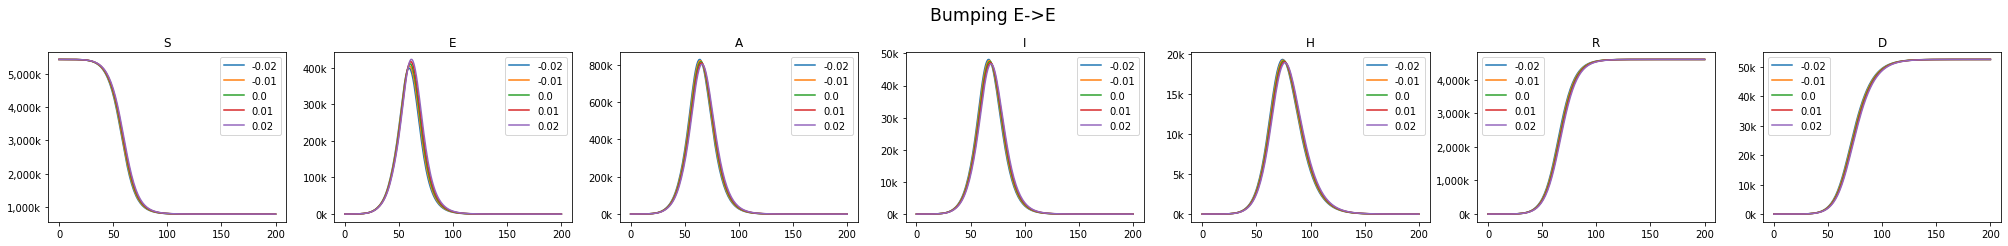

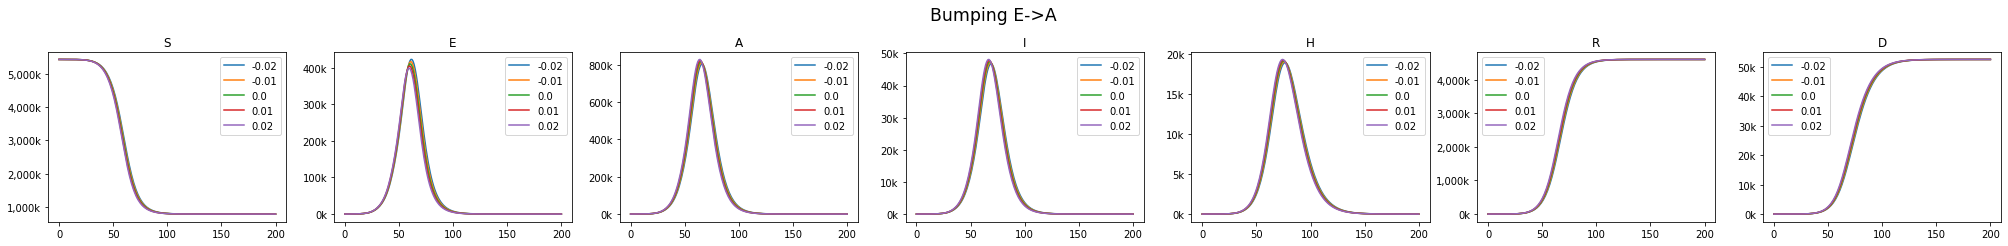

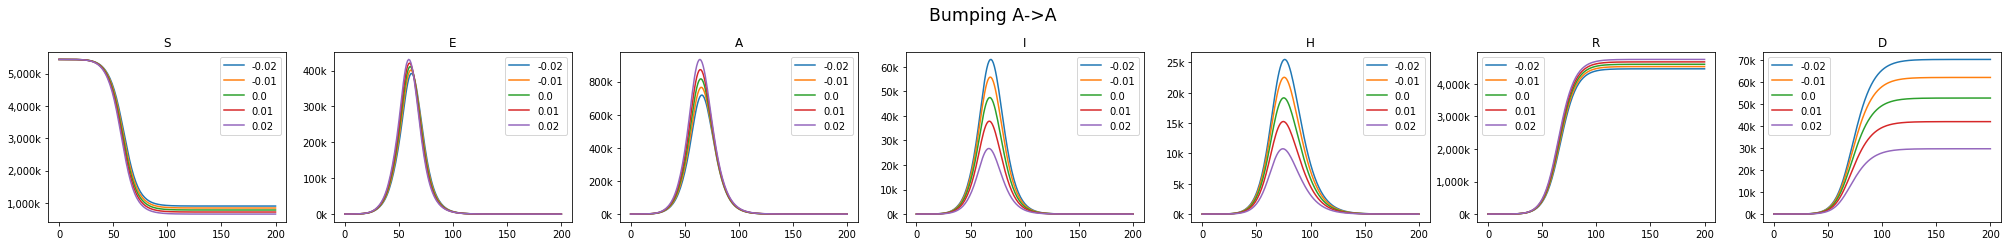

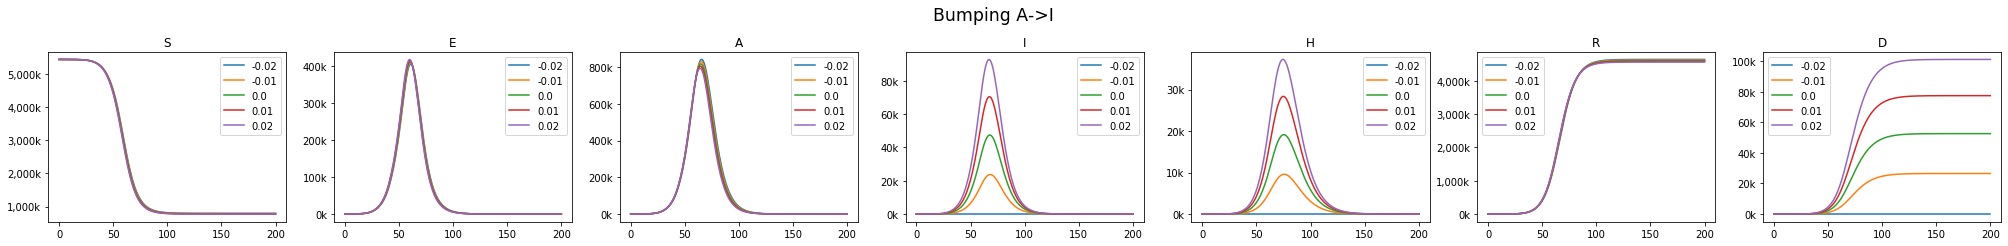

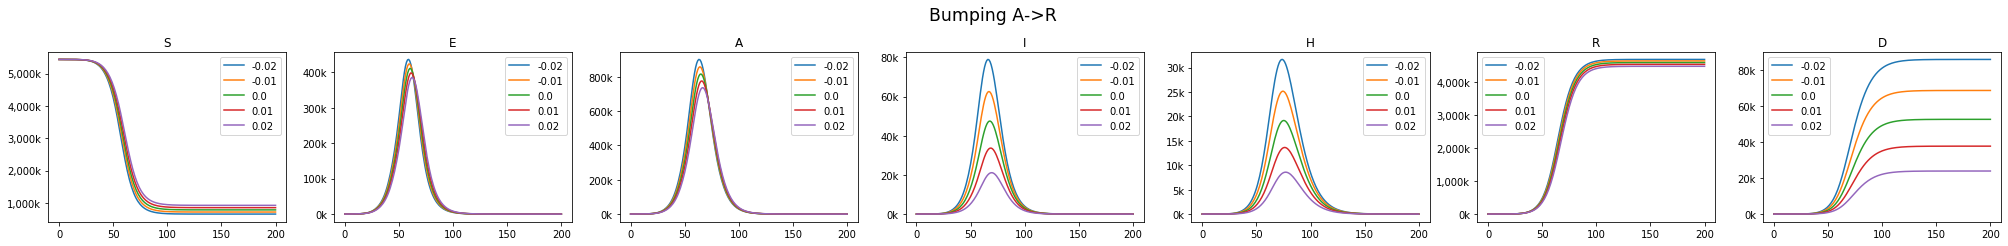

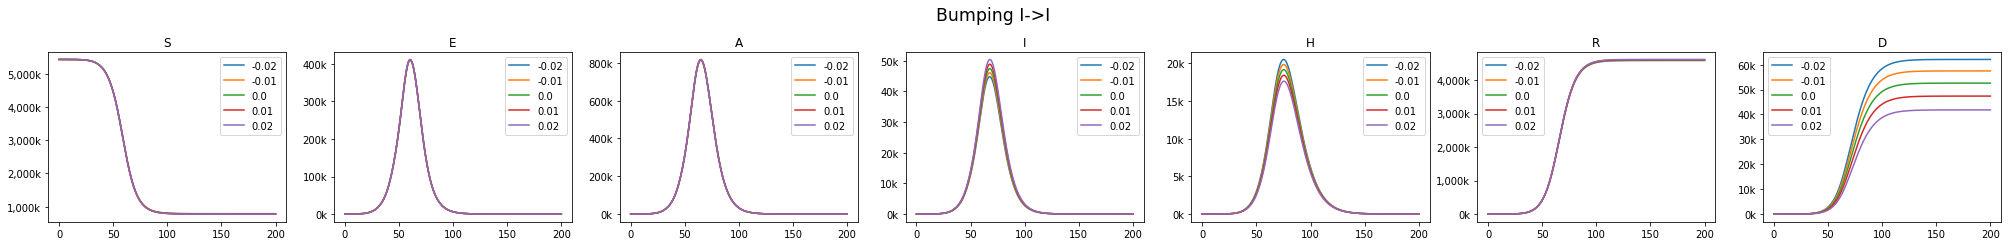

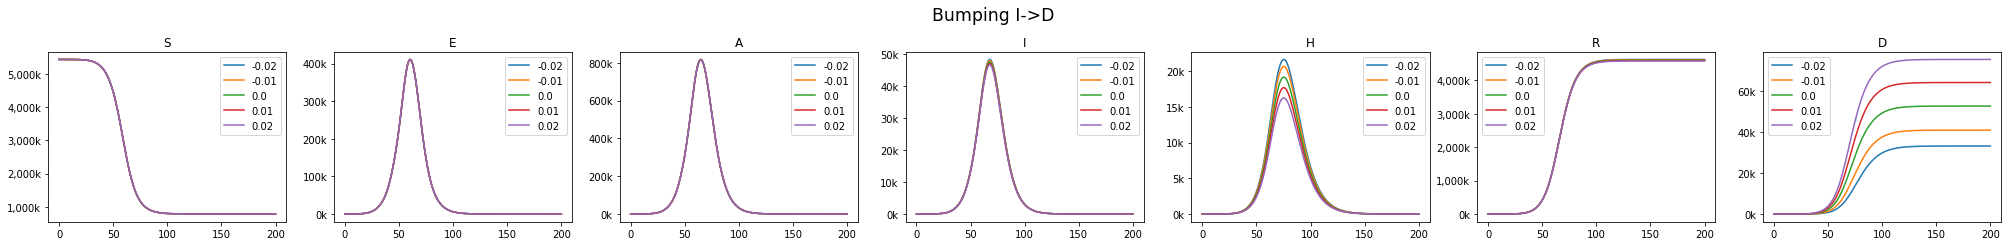

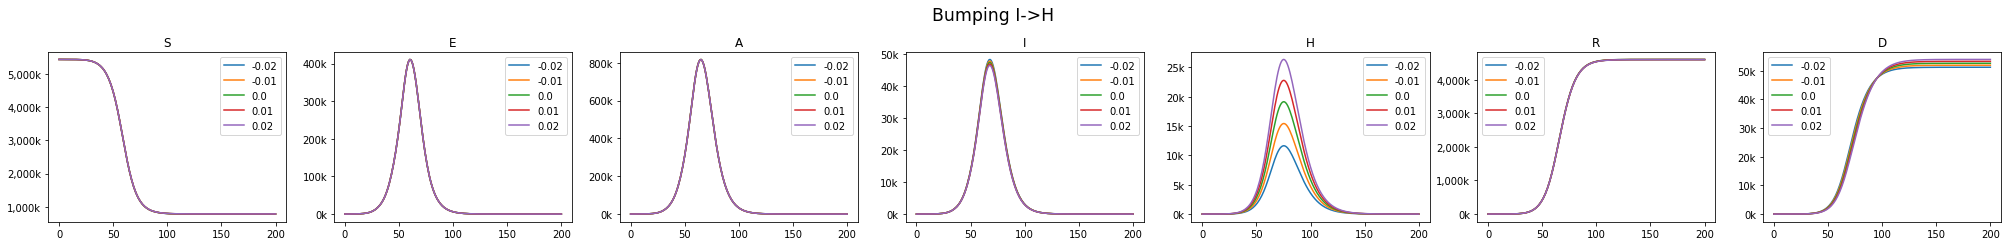

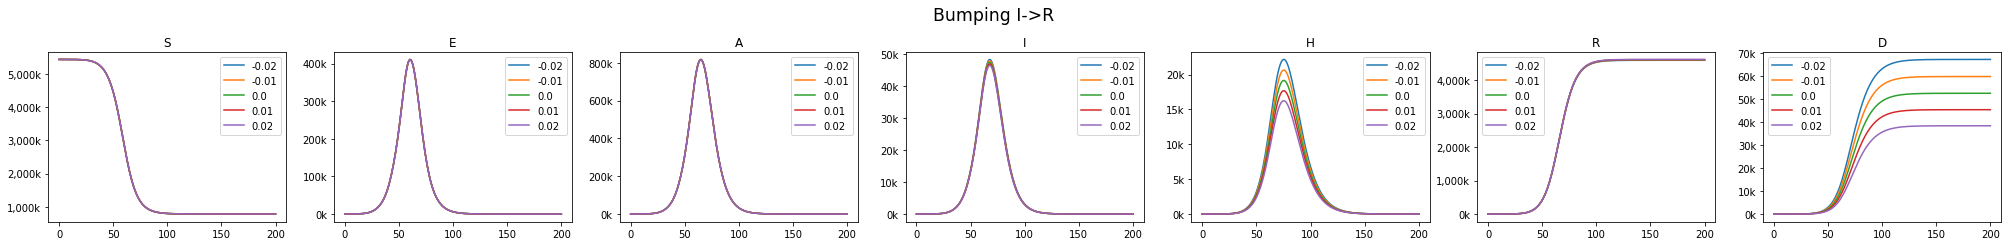

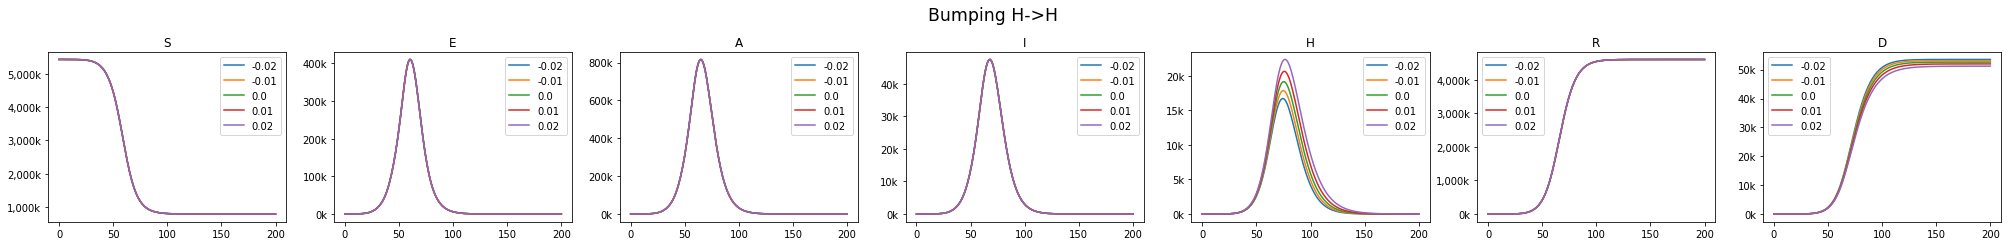

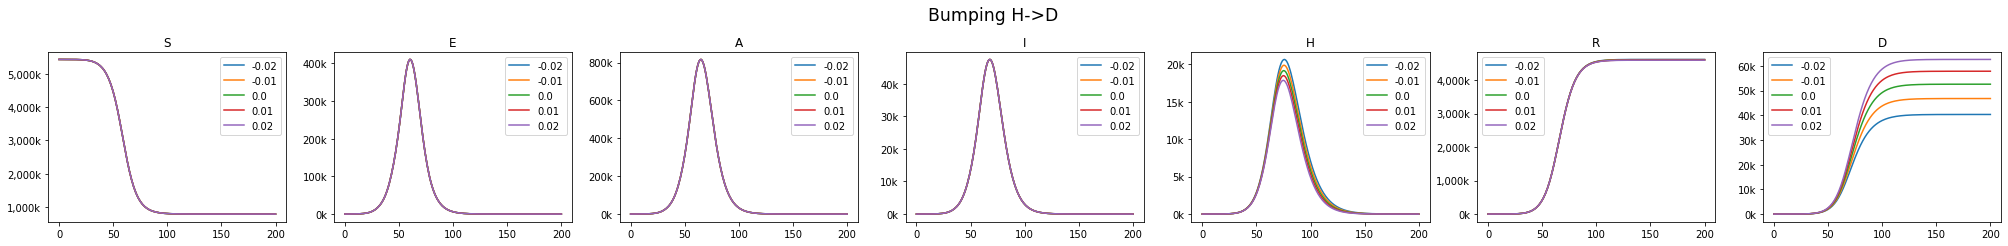

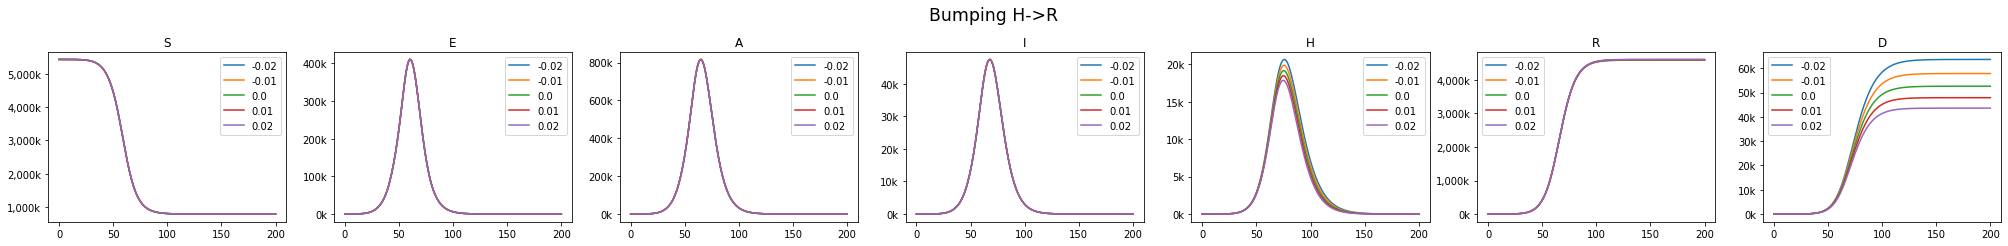

In [123]:
args = create_args()
network = create_original_network(args)

for compartment_1, values in network.progression['70+'].items():
    for compartment_2, proba in values.items():

        if proba == 1.:
            continue
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 3.5), sharex=True)
        fig.suptitle(f"Bumping {compartment_1}->{compartment_2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
            bumped_progression = bump_progression_field(args.compartment_transition, compartment_1, compartment_2, bump)
            bumped_network = create_network(bumped_progression, network.states, network.graph, network.infectionMatrix, network.movementMultipliers)
            res = run_model(bumped_network)
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump)
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

# Change wrt to infection matrix

In [125]:
infectionMatrix = loaders.MixingMatrix(args.mixing_matrix)
print(infectionMatrix)

[0,17): [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]
[17,70): [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]
70+: [[0,17): 0.2, [17,70): 0.2, 70+: 0.2]


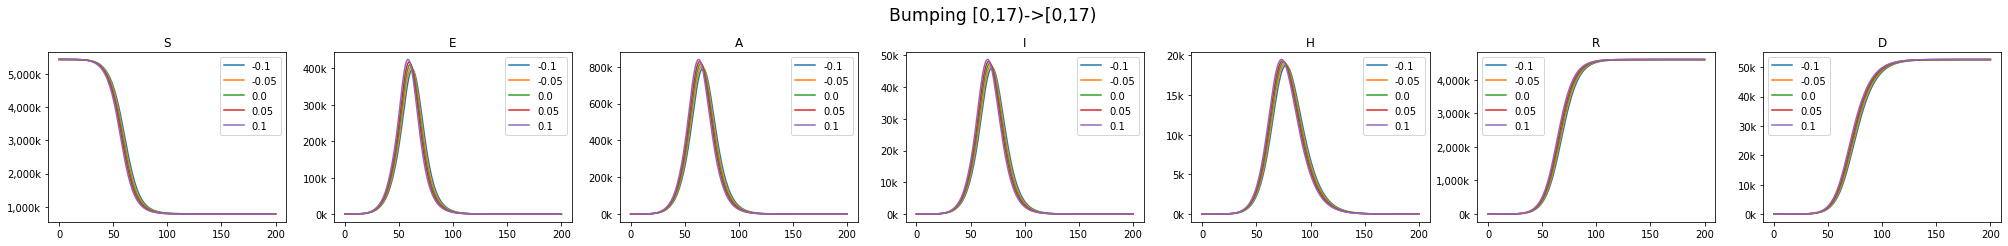

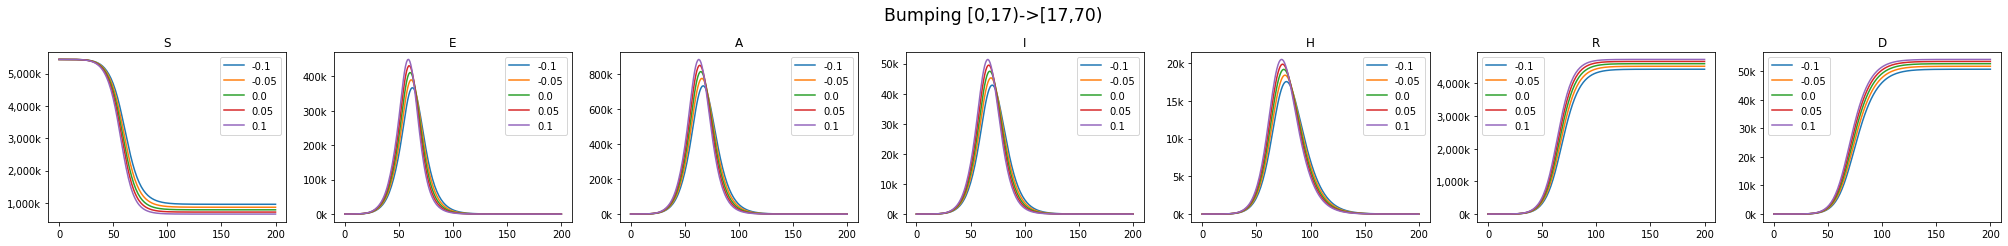

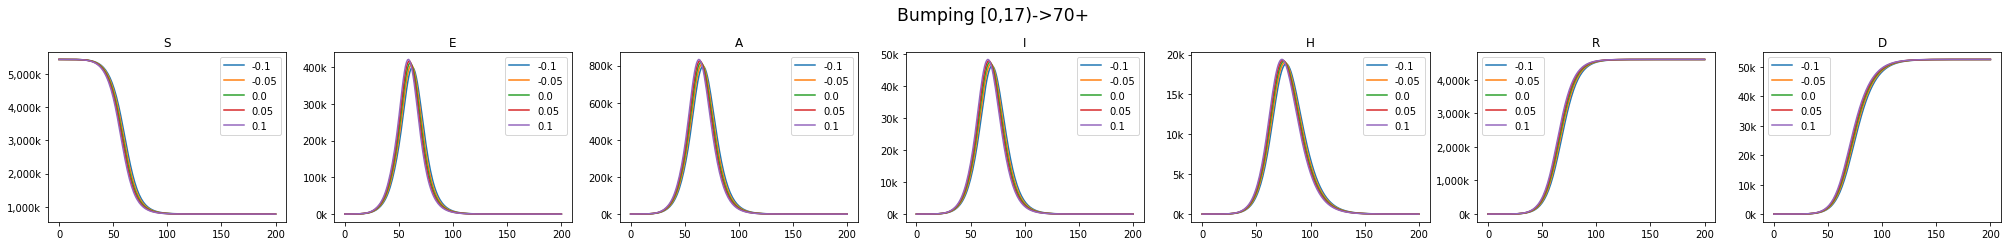

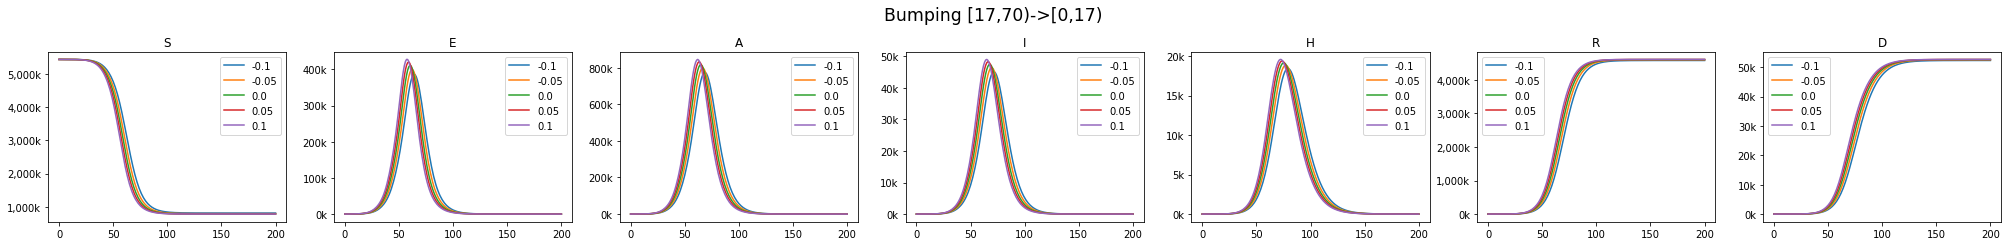

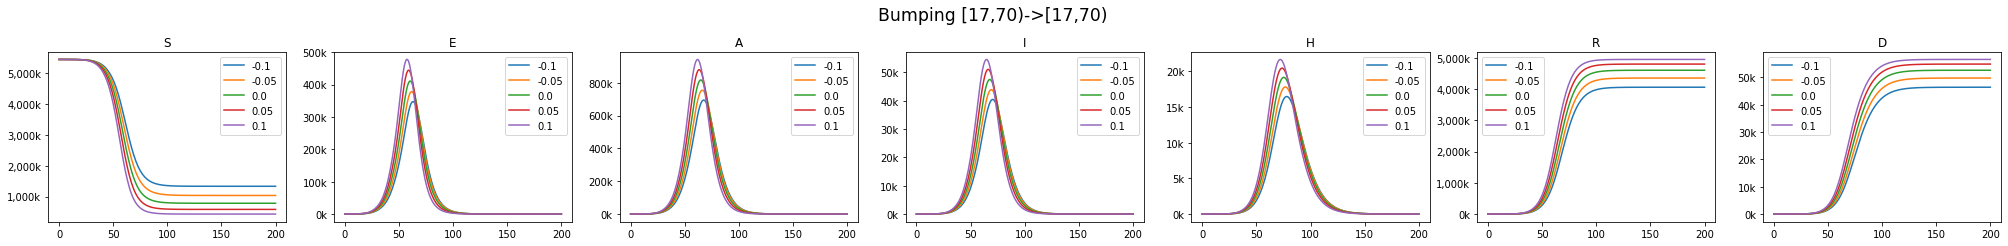

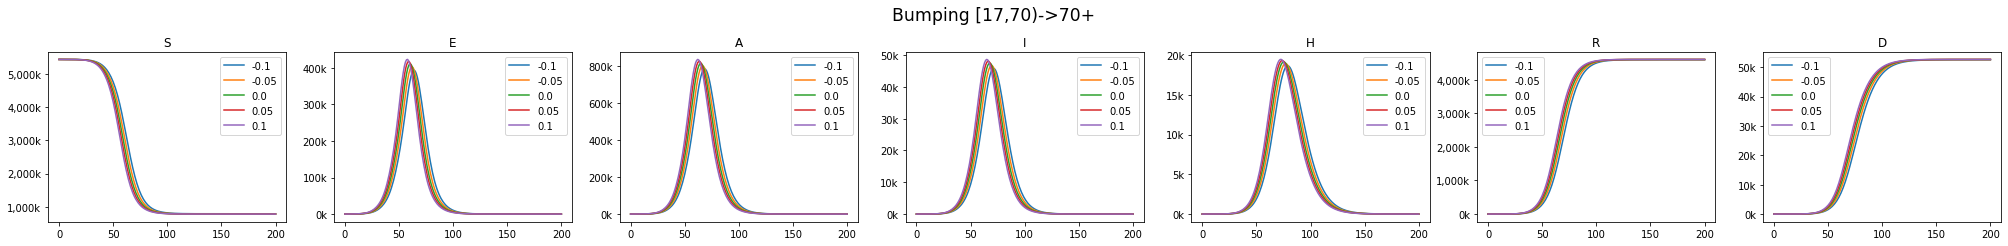

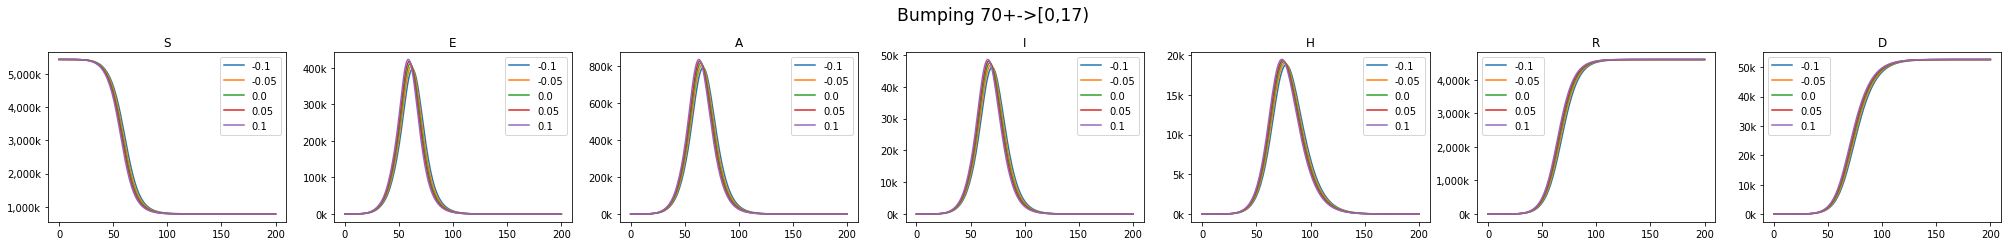

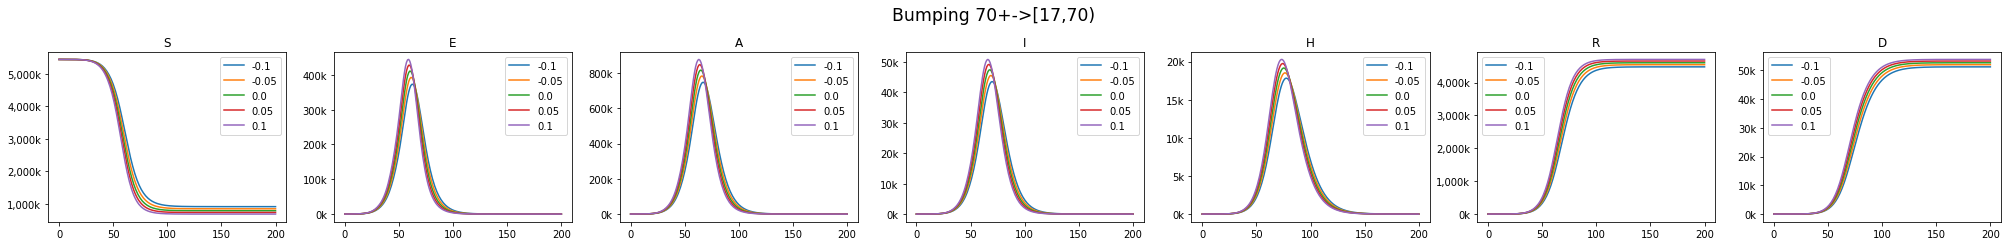

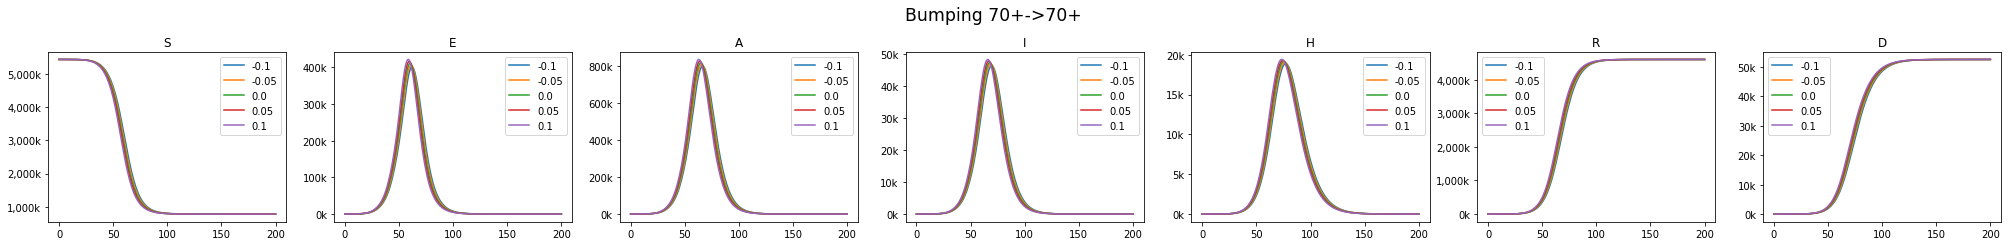

In [161]:
args = create_args()
network = create_original_network(args)

for age_range1, infection_row in network.infectionMatrix._matrix.items():
    for age_range2, contacts in infection_row._entries.items():
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 3.5), sharex=True)
        fig.suptitle(f"Bumping {age_range1}->{age_range2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.1, -0.05, 0., 0.05, 0.1]:
            infectionMatrix = bump_infection_matrix(network.infectionMatrix, age_range1, age_range2, bump)
            bumped_network = create_network(network.progression, network.states, network.graph, infectionMatrix, network.movementMultipliers)
            res = run_model(bumped_network)
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump)
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

# Change wrt to movement multiplier matrix

In [11]:
with open(args.movement_multipliers) as fp:
    movementMultipliers = loaders.readMovementMultipliers(fp)
    
movementMultipliers

{50: Multiplier(movement=0.05, contact=0.05),
 75: Multiplier(movement=0.3, contact=0.3),
 80: Multiplier(movement=0.8, contact=0.8),
 100: Multiplier(movement=0.9, contact=0.9)}

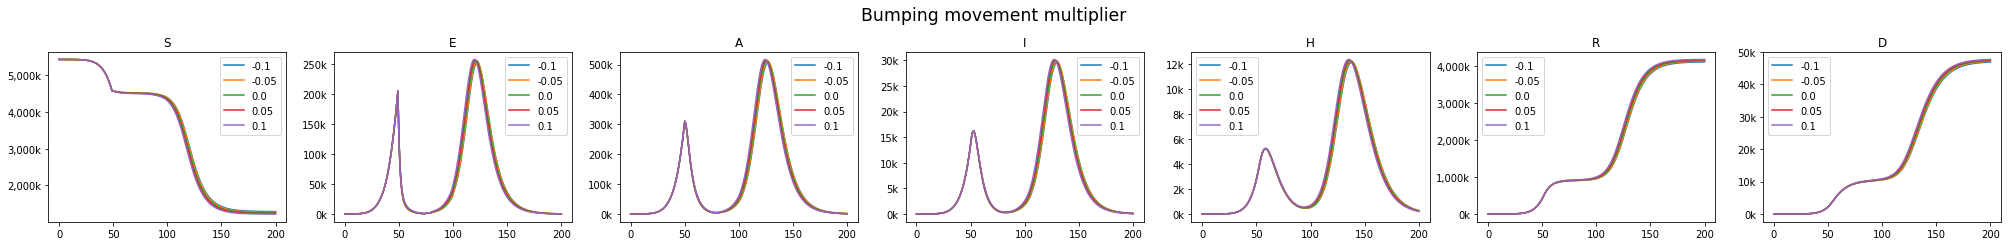

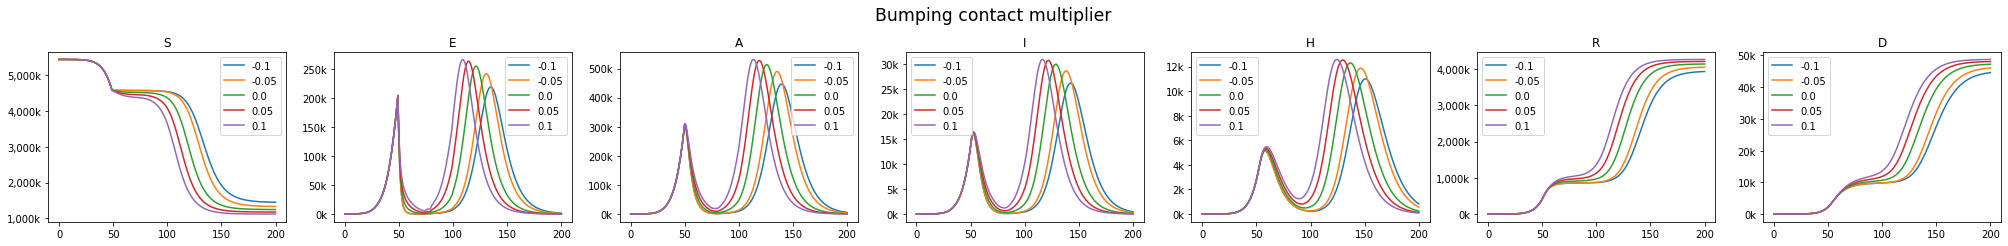

In [25]:
args = create_args()
network = create_original_network(args)

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 3.5), sharex=True)
fig.suptitle(f"Bumping movement multiplier", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.1, -0.05, 0., 0.05, 0.1]:
    movementMultipliers = bump_movementMultipliers(network.movementMultipliers, bump, 0)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers)
    res = run_model(bumped_network)
    res = aggregate_all_boards(res)

    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i], title=col, label=bump)
        axes[i].set_xlabel('')
        axes[i].legend()
        axes[i].yaxis.set_major_formatter(fmt)
        
        
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 3.5), sharex=True)
fig.suptitle(f"Bumping contact multiplier", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.1, -0.05, 0., 0.05, 0.1]:
    movementMultipliers = bump_movementMultipliers(network.movementMultipliers, 0, bump)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers)
    res = run_model(bumped_network)
    res = aggregate_all_boards(res)

    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i], title=col, label=bump)
        axes[i].set_xlabel('')
        axes[i].legend()
        axes[i].yaxis.set_major_formatter(fmt)